In [1]:
import os
import sys
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from math import pi
import h5py
import orbithunter as orb

# Table of contents
<a id='toc'></a>

## [1. Overview: Why orbithunter?](#intro)
    Why and when you should use orbithunter. 

# [2. Examples with the Kuramoto-Sivashinsky Equation](#KSE)
    Demonstrations of utilities using a specific equation

## [2.1 Initialization](#init)
    How to initialize an Orbit with no prior information

## [2.2 Orbit Hunting via Machine Learning (Numerical Optimization)](#hunt)
    How to apply custom and SciPy's numerical methods to search for solutions

## [2.3 Clipping: Extracting Subdomains](#clip)
    Extracting spatiotemporal subdomains from larger Orbits

## [2.4 Reading and Writing Orbit Data](#io)
    How to handle data using the orbithunter API

## [2.5 Gluing: Building Blocks of Turbulence](#glue)
    Combining spatiotemporal configurations of orbits; using orbits as literal building blocks.

## [2.6 Shadowing: Detecting Orbits in Other Orbits](#shadow)
    Detecting orbits which manifest within others; the theoretical motivation behind this project.
    
# [Extras/Future Functionality](#extras)

## [E.1 Gudhi](#gudhi)
    How to use orbits with Gudhi, persistent homology tools (if extra package requirements are satisfied)

## [E.2 Keras](#keras)
    How to use orbits with Keras (if extra package requirements are satisfied)

    
## [E.3 Technical notes from the author](#footnotes)
    Comments on various portions of the notebooksfor a more technical audience


# 1. Overview: Why orbithunter?

<a id='intro'></a>

## A terse non-technical explanation

Certain equations are hard to solve for two reasons: 1. the number of variables, 2. the relations between those variables.
In fact, for a certain class of equations, nonlinear equations, there are seldom any exact solutions; they must
be solved using computers. In certain settings this is hard, even for computers to manage, and so new tools
must be developed. Orbithunter offers itself as one of these tools. 


## How to do it

By formulating turbulence as a space-time, variational formulation we can still find the same periodic orbits
in the dynamical systems approach; however, spacetime affords us with new capabilities not seen elsewhere. such as:

- The ability to find exponentially unstable solutions starting with modulated random noise
- The ability to include spatiotemporal domain sizes to vary as free parameters; essentially allowing the equations to     determine the important scales (or "learn" in machine learning parlance). 
- The ability to cut and paste (quite literally) periodic orbits together in a manner that is both supported by theory
  and also previously attempted in fluid dynamics research. 

# 2. Examples using the Spatiotemporal Kuramoto-Sivashinsky Equation
**[Return to table of contents](#toc)**
<a id='KSE'></a>

Each spatiotemporal solution to the KSE is a scalar spatiotemporal velocity field $u(t,x)$ which satisfies the equation
\begin{equation}
F(u) = u_t + u_{xx}+ u_{xxxx} + \frac{1}{2}\partial_x u^2 = 0
\end{equation}

## 2.1 Orbit Initialization

**[Return to table of contents](#toc)**
<a id='init'></a>

Initial conditions can be easily initialized with random modulated noise by 

    1. Initialize an OrbitKS instance
    2. Use the populate method to fill its parameters and state

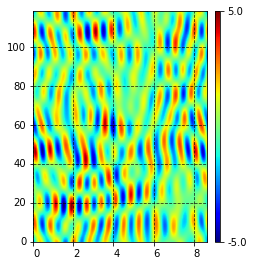

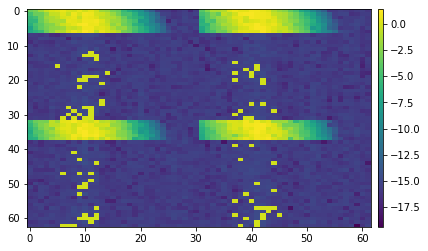

In [2]:
np.random.seed(0)
orbit = orb.OrbitKS().populate(seed=0, attr='all', discretization=(64, 64),
                               spatial_modulation='gaussian',
                              temporal_modulation='truncate').rescale(5)
orbit.plot(padding=True)
orbit.mode_plot()

The plots correspond to the physical field and the spectrum of spatiotemporal Fourier modes populated by modulation
via a specific choice out of a collection various strategies that are best left explained elsewhere. The mode spectrum corresponds to
the combinations of trigonometric $\sin, \cos$ basis functions.

In [3]:
res = orbit.cost()
print(f"The cost function before any numerical optimization is equal to {res:.5f}")

The cost function before any numerical optimization is equal to 8807.93720


## 2.2 Finding periodic orbits via machine learning (nonlinear optimization).

**[Return to table of contents](#toc)**
<a id='hunt'></a>

Orbithunter offers high-level access to the SciPy ```optimize```, ```minimize``` and ```sparse.linalg``` solvers and
more. This allows the user to not have to figure out the specific type of input, parse the output, or learn the more involved
entities within SciPy. A soon as the user defines the methods
which can compute their equations, and compute the matrix-vector products with its Jacobian and its adjoint (transpose or complex conjugate, they immediately have access to over 40 numerical algorithms!

While numerical optimization is always available, finding a solution which constitutes an actual periodic orbit within
a prescribed tolerance is never guaranteed; this is the nature of the beast when it comes to nonlinear optimization, local minima can stop any optimization trial in its tracks. Let's apply some machine learning methods (numerical optimization of a cost function) to try to find a solution!

In [4]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
hunting_result = orb.hunt(orbit, methods=('adj', 'adj', 'lsmr'), verbose=False,
                          preconditioning=[True, False, False], maxiter=[20000, 80000, 500],
                          scipy_kwargs={"atol":1e-4,"btol":1e-4})
t1 = time.time_ns()/10**9
print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} iterations for each method")

The numerical optimization took 229.91399931907654 seconds to complete [20000, 80000, 500] iterations for each method


While it took a couple minutes, the residual of the cost function was reduced from $\mathcal{O}(10^{4})$ to $\mathcal{O}(10^{-2})$ without much effort or tuning! The corresponding velocity field has begun to look more like a "typical" solution of the KSE.

## 2.3 Clipping: Extracting Subdomains

**[Return to table of contents](#toc)**
<a id='clip'></a>

Numerical optimization is not the main contribution of orbithunter; in fact creating random initial conditions and finding solutions from them, while impressive (we boast) can be done in a much smarter method. 

The domains can be extracted either via the ```clip``` utility or via regular array slicing! The benefit of the
more contrived ```clip``` is the ability to specify dimensions from the visualization as opposed to having to guess
array indices; also, you can specify the ```Orbit``` type to return the result as by passing a type to the argument 
```clipping_type```, e.g. ```clipping_type=RelativeOrbitKS``` (note: type not instance)

First however let us import a submodule that has an integration routine defined. 

In [5]:
import orbithunter.ks.physics as ks

In [6]:
integrated_trajectory = orb.OrbitKS(parameters=(500, 500)).populate(attr='state', seed=0)
# First only return the endpoint so memory is not allocated for the entire integrated trajectory. 

integrate_keywords = {'integration_time':1000, 'verbose':True,
                                          'starting_point':0, 'step_size':0.25, 'return_trajectory':False}
integrated_trajectory = ks.integrate(integrated_trajectory, **integrate_keywords)
print('')
# alternative handling of keyword arguments for example
integrated_trajectory = ks.integrate(integrated_trajectory, integration_time=500, verbose=False,
                                          starting_point=0, step_size=0.25, return_trajectory=True)

Integration progress [#########################]


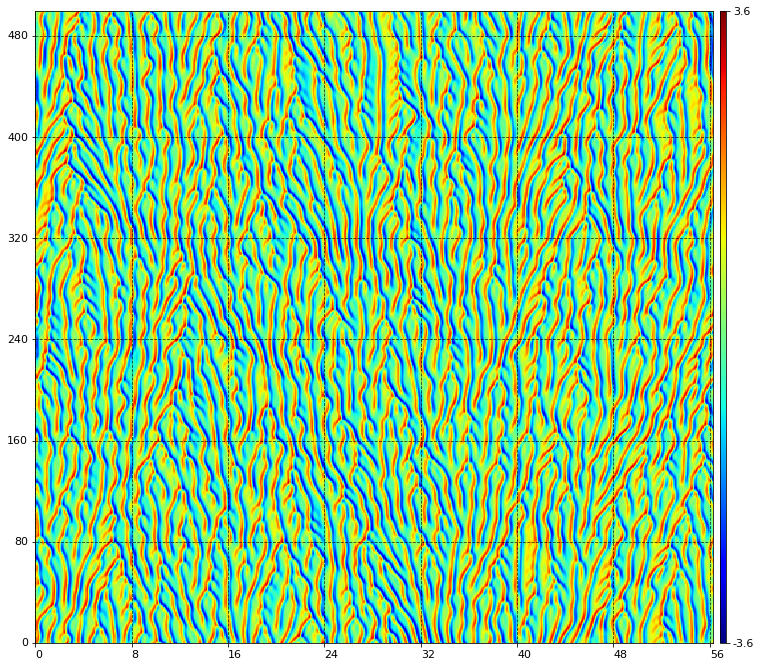

In [7]:
integrated_trajectory = integrated_trajectory.resize(1024, 512)
integrated_trajectory.plot(padding=False)

Domains can be extracted either via the ```clip``` utility or via regular array slicing! The benefit of the
more contrived ```clip``` is the ability to specify dimensions from the visualization as opposed to having to guess
array indices; also, you can specify the ```Orbit``` type to return the result as by passing a type to the argument 
```clipping_type```, e.g. ```clipping_type=RelativeOrbitKS``` (note: type not instance)

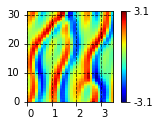

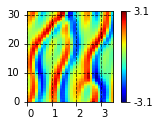

In [8]:
sliced_subdomain = integrated_trajectory[-64:, :32]
clipped_subdomain = orb.clip(integrated_trajectory, ((0, sliced_subdomain.t), (0, sliced_subdomain.x/(2*pi*np.sqrt(2)))))
integrated_trajectory[-64:, :32].plot()
clipped_subdomain.plot()

Show that the clippings are in fact exactly the same by plotting the difference of the fields

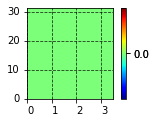

In [9]:
(sliced_subdomain-clipped_subdomain).plot()

These clippings can be used to find larger orbits, but first it would befit us to find the orbit that we claim
these clippings shadow. 


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "(t, x, s)": [31.25, 31.25, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 8722.488572803968
Target cost tolerance : 1e-06
Maximum iteration number : 50000
Preconditioning : True
-------------------------------------------------------------------------------------------------
#################################################
 cost=1.8020075 after 5000 adjoint descent steps. Parameters=(33.44586070982437, 31.250331293102292, 0.0)
#################################################
 cost=1.0726172 after 10000 adjoint descent steps. Parameters=(34.25016648799164, 31.250362059686257, 0.0)
#################################################
 cost=0.8118077 after 15000 adjoint descent steps. Parameters=(34.78006531168208, 31.25037548165999, 0.0)
#############################################

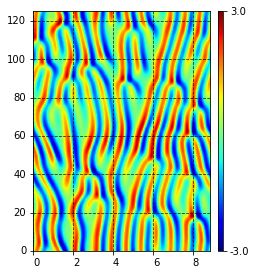

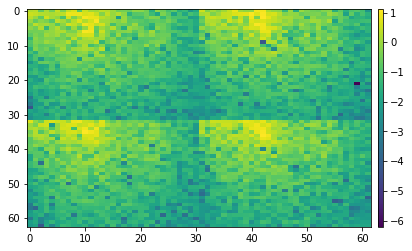

In [10]:
t0 = time.time_ns()/10**9
methods=('adj', 'lsmr')
clip_result = orb.hunt(clipped_subdomain.transform(to='modes').resize(32,32), maxiter=[50000, 25],
                      methods=methods, preconditioning=[True, False], verbose=True, scipy_kwargs={'atol':1e-6, 'btol':1e-6})
t1 = time.time_ns()/10**9
print(f"dimensions {hunting_result.orbit.dimensions()}")
print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} iterations for each method")
print(f"The residual of the optimization result is {hunting_result.orbit.cost()}")
hunting_result.orbit.plot(padding=True)
hunting_result.orbit.mode_plot()

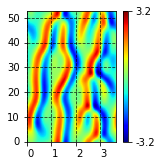

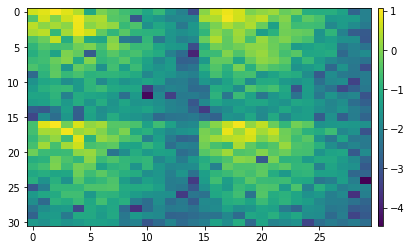

In [11]:
clip_result.orbit.plot(padding=True)
clip_result.orbit.mode_plot()

The idea is "simple" instead of describing chaotic nonlinear pdes as
exponentially unstable dynamical systems (initial value problem) it is instead treated as a $(D+1)$ dimensional boundary value problem. This work only uses variational methods; time integration is possible but it is in no way involved
in the optimization or any other process.

## 2.4 Reading and Writing Orbit Data

**[Return to table of contents](#toc)**
<a id='io'></a>

Before proceeding to the next section, using Orbits as the building blocks of turbulence, it is
useful to read in saved Orbit data that corresponds to fully converged solutions (not a requirement for saving, of course).
This is accomplished via Orbithunter high-level API which allows for quick and convenient importation using the ```h5py```
package.

All that the user must do is have previously saved an Orbit instance using its ```Orbit.to_h5()``` method.
This essentially writes the state array as a h5py.Dataset and the Orbit's attributes as its attributes.
To read in a single or multiple Orbits, all that is required is providing a filename and the names of h5py.Datasets 
(or h5py.Groups !) within the file.

In [12]:
# provide dataset/group names as separate arguments or as tuple.
imported_orbits = orb.read_h5('./data/tiles.h5', "default/double_streak", "default/defect", "default/double_streak")
imported_orbits

[EquilibriumOrbitKS({"shape": [64, 64], "basis": "field", "(t, x, s)": [0.0, 13.02, 0.0]}),
 RelativeOrbitKS({"shape": [64, 64], "basis": "field", "(t, x, s)": [17.151, 13.02, -3.313]}),
 EquilibriumOrbitKS({"shape": [64, 64], "basis": "field", "(t, x, s)": [0.0, 13.02, 0.0]})]

For convenience, these can also be imported as a dictionary using the ```read_tileset``` function and provided keys along
with the dataset names

In [13]:
# provide dataset/group and keys as tuples
imported_orbit_dict = orb.read_tileset('./data/tiles.h5', (0, 1, 2),
                                      ("default/double_streak", "default/defect", "default/wiggle"))
imported_orbit_dict

{0: EquilibriumOrbitKS({"shape": [64, 64], "basis": "field", "(t, x, s)": [0.0, 13.02, 0.0]}),
 1: RelativeOrbitKS({"shape": [64, 64], "basis": "field", "(t, x, s)": [17.151, 13.02, -3.313]}),
 2: AntisymmetricOrbitKS({"shape": [64, 64], "basis": "field", "(t, x, s)": [17.151, 17.591, 0.0]})}

A ```h5py.Group``` can be thought of as a folder/directory like structure which contains ```h5py.Dataset``` objects. If a mixture of group and dataset names are provided, an intuitive list is returned; elements corresponding to groups are themselves lists, single datasets are objects. I.e.
 

In [14]:
dataset_and_group_names = ("default/double_streak", "default/", "default/double_streak")
[type(x) for x in orb.read_h5('./data/tiles.h5', dataset_and_group_names)]

[orbithunter.ks.orbits.EquilibriumOrbitKS,
 list,
 orbithunter.ks.orbits.EquilibriumOrbitKS]

## 2.5 Gluing: Building Blocks of Turbulence

**[Return to table of contents](#toc)**
<a id='glue'></a>

One of the most impressive accomplishments is the ability to use ```Orbit```s as many have thought should be possible;
as the building blocks of turbulence. Given a dictionary whose values are Orbits, we can translate arrays of keys into
arrays of orbits, and then ```glue``` or ```tile``` those orbits together. 


In [15]:
np.random.seed(5)
symbol_array = (3*np.random.rand(3, 3)).astype(int)
symbol_array

array([[0, 2, 0],
       [2, 1, 1],
       [2, 1, 0]])

The ```tile``` function simply acts as an interface for the ```glue``` function which accepts arrays of symbols as opposed to arrays of Orbits. Hopefully the correspondence between the symbol array (above) and its glued Orbit representation (below) can be seen.

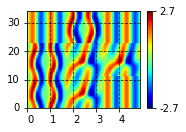

In [16]:
tiled_orbit = orb.tile(symbol_array, imported_orbit_dict, orb.RelativeOrbitKS)
tiled_orbit.plot()

What do we do with this? The most obvious use is to use it as an initial condition for an Orbit hunt.

In [17]:
t0 = time.time_ns()/10**9
glue_intermediate_result = orb.hunt(tiled_orbit.resize().resize(64, 32).transform(to='modes'), methods=('adj', 'adj'),
                                    maxiter=[20000, 5000],
                            preconditioning=[True, False], verbose=True)
t1 = time.time_ns()/10**9


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [63, 30], "basis": "modes", "(t, x, s)": [34.302, 43.63, 0]})
Constraints : {'t': False, 'x': False, 's': False}
Initial cost : 1405.8423088285467
Target cost tolerance : 1e-06
Maximum iteration number : 20000
Preconditioning : True
-------------------------------------------------------------------------------------------------
#################################################
 cost=3.7122523 after 5000 adjoint descent steps. Parameters=(35.36702076468905, 43.63021080871468, -2.5721223744957737)
#################################################
 cost=2.2776136 after 10000 adjoint descent steps. Parameters=(35.579334626065354, 43.63021218472554, -2.74207432588011)
#################################################
 cost=1.6127589 after 15000 adjoint descent steps. Parameters=(35.71602492426634, 43.6302128492556, -2.89439438

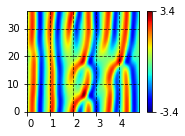

In [18]:
glue_intermediate_result.orbit.plot(padding=True)

In [19]:
print(''.join([f"Numerical optimization with methods={'lsmr'} took {t1-t0} seconds to compute {glue_intermediate_result.nit}"
               f" iterations and finished with residual {glue_intermediate_result.orbit.cost()}."]))

Numerical optimization with methods=lsmr took 46.386000871658325 seconds to compute [20000, 5000] iterations and finished with residual 0.9542432116581994.


In [20]:
t0 = time.time_ns()/10**9
glue_result = orb.hunt(glue_intermediate_result.orbit,
                       methods=('l-bfgs-b',),
                       maxiter=[20],
                       verbose=True,
                       scipy_kwargs=[{"tol":1e-7}],
                       progressive=True  # progressive means that after each 
                      )
t1 = time.time_ns()/10**9


-------------------------------------------------------------------------------------------------
Starting l-bfgs-b optimization
Initial guess : RelativeOrbitKS({"shape": [63, 30], "basis": "modes", "(t, x, s)": [36.489, 43.565, -3.006]})
Constraints : {'t': False, 'x': False, 's': False}
Initial cost : 0.9542432116581994
Target cost tolerance : 1e-06
Maximum iteration number : 20
-------------------------------------------------------------------------------------------------
############
insufficient cost decrease, (new_cost - cost) / max([new_cost, cost, 1])<ftol decrease ftol to proceed, terminating with cost 1.1524056020365394e-05


In [21]:
print(''.join([f"Numerical optimization with methods={'lsmr'} took {t1-t0} seconds to compute {glue_result.nit}"
               f" iterations and finished with residual {glue_result.orbit.cost()}."]))

Numerical optimization with methods=lsmr took 44.28099870681763 seconds to compute 13 iterations and finished with residual 1.1524056020365394e-05.


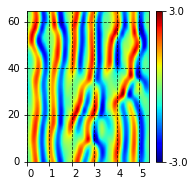

In [22]:
glue_result.orbit.plot(padding=True)

## 2.6 Shadowing: Detecting Orbits in Other Orbits

 [Return to table of contents](#toc) 
<a id='shadow'></a>

One of the more involved computations is to search for the shadowing of smaller orbits within larger orbits. This
component of orbithunter is still in flux due to how difficult it was to generalize to arbitrary shapes and geometries; I think I went slightly overboard with this part. 

The main utilities are ```shadow```, ```cover```, ```fill```. The main concepts/terminology needed to understand these
functions are the following.

     Base Orbit  : An Orbit or near Orbit that is of large spatiotemporal extent
     Window  : A subdomain of spacetime; kernel of convolutional neural network for those with CNN experience.  
     Window Orbit  : An Orbit whose state will be searched for in the base orbit.
     Pivot  : "Top left corner" (first element, 0 along each axis) position of the window within the base orbit. Each window
              position is identified by its "pivot" and its "span" (dimensions). For example; a window with dimensions (32, 32, 32) at a pivot of 
             (1, 2, 3) would have indices in the extent (range(1, 33), range(2, 34), range(3, 35)), before any boundary conditions are taken into account.  
     Shadowing  : When an orbit appears as a subdomain within another, larger Orbit. Developed in periodic orbit theory.
     Cover  : The process of using a collection of windows to find shadowing detections, with the hope that every region of spacetime
              contains a detection of an orbit. Each window is  scored independently, unless replacement=False. 
     Fill  : Same as cover, except all windows are scored simultaneously. For each position, whichever window has the best score is recorded,
             creating an empirical distribution of the proportion of area covered by each window. 

The metric for detecting shadowing is a highly delicate/unknown problem still under investigation, as such, I made it so that it can be provided as a callable which can return anything that can be stored in a float dtype numpy array. 
Provided below are the some examples of how to provide callables as metric functions. 

In [23]:
from orbithunter.shadowing import _pad_orbit
base = orb.read_h5('./data/small_patches.h5', '0')
hull = (32, 32)
periodicity=(False, False)
windows = [x.transform(to='field').to_fundamental_domain() for x in orb.read_h5('./data/minimal_cover.h5')]

strictness = 0 
critical_amp_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_amp_diff = file['defect/amplitude_difference_fundamental_domain'][...][strictness]


critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff = file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness]

amplitude_difference = orb.scoring_functions('amplitude')

# Use a mask to select only a few pivots because this is a joke example anyway
np.random.seed(2)
mask = np.ones(_pad_orbit(base, hull, periodicity).shape,dtype=bool)
mask = (1000*np.random.rand(*mask.shape)).astype(int).astype(bool)

critical_amp_diff *= 1000

orbit_cover = orb.OrbitCover(base, windows[:1], [critical_amp_diff],
                             periodicity=(False, False),                                   
                             scoring_function=amplitude_difference,
                             mask=mask)

t0ad=time.time_ns()/10**9
amplitude_difference_cover = orb.cover(orbit_cover,
                                   verbose=False)
t1ad=time.time_ns()/10**9
print('\nAmplitude metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

l2dmfc = orb.scoring_functions('l2_density_mfc')


orbit_cover = orb.OrbitCover(base, windows[:1], [critical_amp_diff],
                             periodicity=(False, False),                                   
                             scoring_function=l2dmfc,
                             mask=mask)


t0ad=time.time_ns()/10**9
ls_diff_cover = orb.cover(orbit_cover, verbose=False)

t1ad=time.time_ns()/10**9
print('\nL2 difference metric with mean flow correction covering took {:.2f} seconds to complete'.format(t1ad-t0ad))


Amplitude metric covering took 0.75 seconds to complete

L2 difference metric with mean flow correction covering took 0.75 seconds to complete


The `cover` function returns an array of scores in "pivot format", wherein the elements represents a ***window position***; that is, each pixel should be interpreted as "if I put a window here and then score it, I receive this value". Because of boundary conditions, it is convenient to make (and keep) this array larger than it "needs to be". To remove the elements which
do not provide useful information, we can trim the score array and replot.

<Figure size 432x288 with 0 Axes>

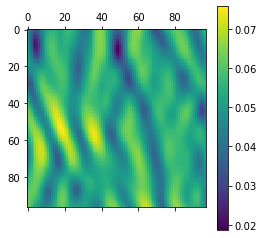

In [24]:
plt.figure()
plt.matshow(ls_diff_cover.trim()[0])
plt.colorbar()
plt.show()

or use the values to map them to the "orbit format", which plots spacetime with the smallest possible values taken in each region of spacetime; it is essentially mapping a single pixel back into a domain the small shape as the window used to produce
the score.

<Figure size 432x288 with 0 Axes>

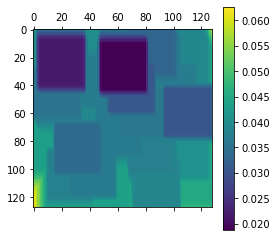

In [25]:
plt.figure()
plt.matshow(amplitude_difference_cover.map(masked=False)[0])
plt.colorbar()
plt.show()

## Odd geometries

Likewise, it is often the case that "odd" geometries; those which do not mimic n-dimensional arrays, are shadowed. 
#### What to do?

To account for this, and all other possible types of transformations of discrete volumes, a painstaking effort was made to implement generalized code which supports arbitrary coordinate tranformations. That is, you provide a function which can
map an array of coordinate indices (hypercube) into whatever shape you desire. And I really mean, **WHATEVER** shape you desire that can be represented by a set of discrete points. 

The orbithunter code handles the mapping of the indices and checks against the boundary conditions to ensure that regardless of shape, no "out of bounds" points are used. Out of bounds in this case means, for example, the zero padded region of zeros in aperiodic dimensions.

To really make this point hit home, here's a simple example of using an exotic computational domain.

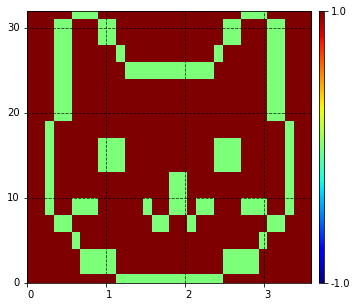

In [26]:
dat = orb.read_h5('./data/small_cat.h5')
dat.parameters = dat.shape
dat.plot(figsize=(5, 5))


def catmap(coordinates, **kwargs):
    return np.concatenate(tuple(coord[np.where(dat.state==0)].reshape(1,-1) for coord in coordinates))

orbit_cover = orb.OrbitCover(base,
                             windows[:1],
                             [critical_amp_diff],
                             periodicity=(False, True),
                             coordinate_map=catmap,
                             mask=mask,
                             min_overlap=1,
                             return_oob=False,
                             ignore_oob=False
                             
                            )

orbit_cover = orb.cover(orbit_cover,
                        pivot_mask=mask,
                        verbose=False) 

The scores in "pivot space".

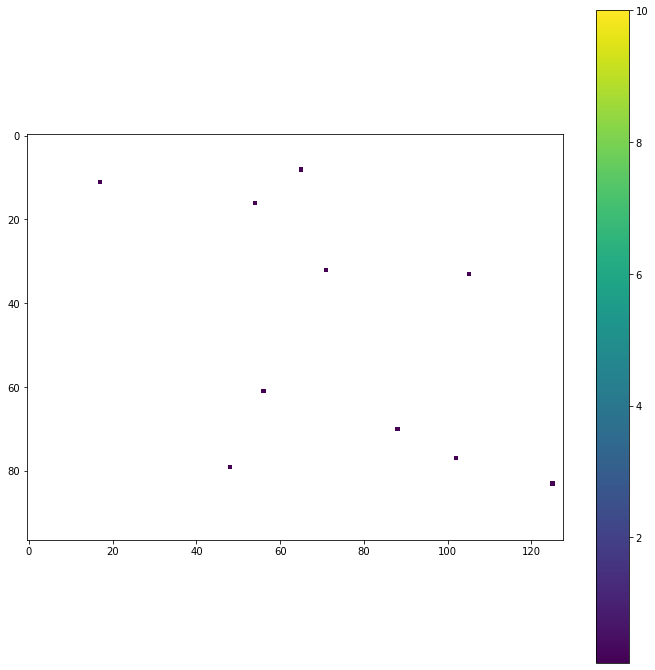

In [27]:
plt.figure(figsize=(12,12))
plt.imshow(orbit_cover.trim()[0], vmax=10, interpolation='none')
plt.colorbar()
plt.show()

The scores mapped into "orbit space".

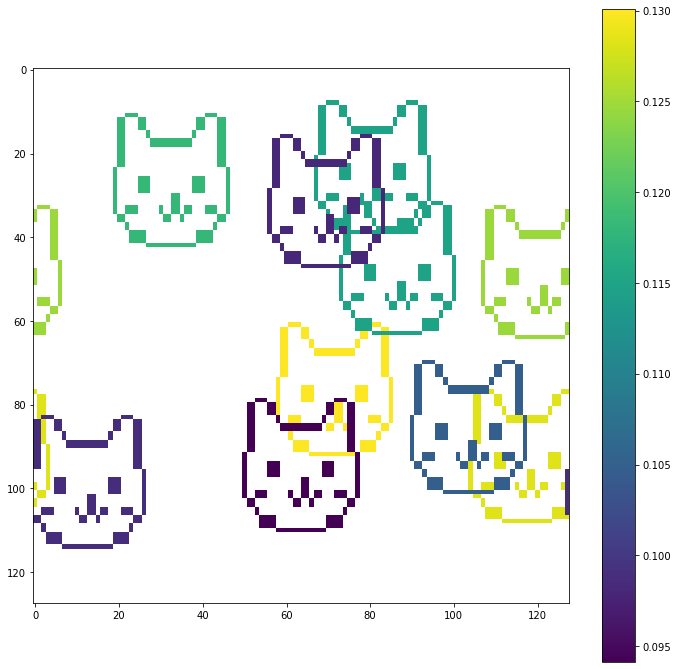

In [28]:
plt.figure(figsize=(12,12))
plt.imshow(orbit_cover.map()[0], interpolation='none')
plt.colorbar()
plt.show()

***Note the periodicity in space (x-axis) and the lack thereof in time (y-axis)***

# Conclusion

What do you do with all of this? The main goal and likely the main interest in this package are the tools and high level API for finding periodic orbits of differential equations. The spatiotemporal tools, clipping, gluing, shadowing, can be used
to find more periodic orbits, in a more intelligent manner. Intelligent here means that better initial conditions leads to
more success. Theoretically, the gluing and shadowing tools can be used to probe the admissibility of patterns via what is known as *symbolic dynamics*.

What I designed this to be is a framework so that not every physicist has to reinvent the wheel to study differential equations. This enables more collaboration and comparison of results. The second reason I developed this was to introduce
a variational form of solving differential equations typically modeled as dynamical systems, which, as previously discussed, is
subject to exponential instabilities, but a variational spatiotemporal formulation is not. 

# Extra comments
**[Return to table of contents](#toc)**
<a id='extras'></a>

The extras, persistent homology and tensorflow/keras tools are available (the latter to limited degree) but the popularity of the package does not yet merit exposition, I think.

## [E.1 Gudhi](#gudhi)
    How to use orbits with Gudhi, persistent homology tools (if extra package requirements are satisfied)

## [E.2 Keras](#keras)
    How to use orbits with Keras (if extra package requirements are satisfied)

## Terse technical explanations

One of the main focuses of nonlinear dynamics and chaos research is the phenomenon of turbulence;
often synonymous with the Navier-Stokes equation. In the past twenty or so years, computational advances
have allowed for more advanced numerical experiments and investigations, each of which hoping to illuminate
the dark depths of the phenomenon of turbulence. 

Simulations of fluid flow have been used extensively in control and design problems e.g. airplane wings.
However, to get a general description of turbulence, one that is not bound to specific geometrical boundary conditions,
a more fundamental explanation is needed.

The nonlinear dynamicist's approach was to put turbulence under a microscope, looking at the minimal contains
required to sustain it. Naturally these computations began with "minimal cells"; computational domains large enough to sustain
turbulence yet remain computationally tractable; this might be smaller than you might imagine, representing
only small segments of pipe or plane Couette flow. By abstractifying fluid flow as a traversal of a
high dimensional space (technically infinite), periodic orbit theory was used to show that special solutions,
those which manifest as time invariant sets, shape the geometry of the state-space by virtue of their stable
and unstable manifolds. The instabilities, exponential in nature, prevent any long time prediction and are
the main instigator in all of this. 

We can avoid these exponential instabilities by transforming our exponentially unstable initial value problem into
a variational, dynamics-less boundary value problem; by the conceptual migration to spacetime. This formulates
PDEs as systems of differential algebraic equations, instead.

This walkthrough demonstrates the user friendliness of the orbithunter package as well as its utility in finding unstable periodic orbits of the Kuramoto-Sivashinsky equation. 

These solutions, or initial conditions with which to find solutions, are represented via Python class objects using object oriented programming. Different solutions have different symemtries, which manifest naturally as subclasses. 
These ``Orbit`` objects, the basis of ``orbithunter`` are designed to give high-level access to a complex, scientific API. 

The Orbithunter package currently only supports one equation, however, the [Developer Guide](https://orbithunter.readthedocs.io/en/latest/guide.html) offered on the readthedocs site provides template for
how to implement different equations; the lion's share of the work corresponds to implementing the following numerical methods.


## On hunting

A great example of the instant-access property is in the usage of SciPy's ```sparse.linalg``` solvers. These solvers typically take either a Matrix (2d-array) or one of SciPy's ```LinearOperator``` objects. The benefit of using the ```LinearOperator``` objects is that
functions for matrix-vector products can be passed instead of matrices themselves; saving tons of memory. However, with nonlinear equations these matrices will typically depend on the state itself; meaning that the LinearOperator has to be
updated after everycorrection. 

Orbithunter handles literally all of this within its ```hunt``` function. Therefore, as soon as the user defines the methods
which can compute their equations, and compute the matrix-vector products with its Jacobian and its adjoint (transpose or complex conjugate, they immediately have access to over 40 numerical algorithms implemented by scipy!

I personally like watching output be printed/monitoring the process and so I typically choose ```verbose=True```.
The default numerical method is ```methods='adj'```, one reason for it being the default is that it has access
to the ```preconditioning=True``` keyword argument; it is rescaling the components of the gradient to account for very
stiff linear terms; this includes the changes to domain size, which are rescaled according to 

$\Delta P / P_{\small{\text{current}}}^{k}$

One of the revolutionary abilities of this code is that the domain size is allowed to change, however this must be done
within reason. When starting with random initial conditions and using spectral methods very often the optimization will result in the dimensions $d_i\to\infty$; because the derivatives are inversely proportional to dimension via frequencies $\frac{2\pi n}{d}$